# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
!pip install --upgrade pip

!pip install --upgrade Pillow
!pip install --upgrade matplotlib pillow


In [3]:
# Use this space for any additional import statements you need
from wordcloud import WordCloud 


In [4]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
stop_words = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity 
    (https://en.wikipedia.org/wiki/Lexical_diversity), 
    and num_tokens most common tokens. Return a list with
    the number of tokens, number
    of unique tokens, lexical diversity, number of characters,
    and num_tokens most common tokens.
    """
    
    # Calculate the # of tokens
    num_tokens_total = len(tokens)
    
    # Calculate the # of unique tokens
    num_unique_tokens = len(set(tokens))
    
    # Calculate the total # of characters in all tokens
    num_characters = sum(len(token) for token in tokens)
    
    # Calculate lexical diversity
    if num_tokens_total > 0:
        lexical_diversity = num_unique_tokens / num_tokens_total
    else:
        lexical_diversity = 0.0
    
    # Count token frequencies
    token_counts = Counter(tokens)
    
    # Get the top num_tokens most common tokens
    top_tokens = token_counts.most_common(num_tokens)
    
    if verbose:
        print(f"There are {num_tokens_total} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print("Top {} most common tokens:".format(num_tokens))
        for token, count in top_tokens:
            print(f"{token}: {count}")
   
    return [num_tokens_total, num_unique_tokens, lexical_diversity, num_characters, top_tokens]


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens):
    """
    Remove stop words from a list of tokens.

    Args:
        tokens (list): List of tokens.

    Returns:
        list: List of tokens with stop words removed.
    """
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens


def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

    
def tokenize(text):
    """
    Split text on whitespace and return tokens.

    Args:
        text (str): Input text.

    Returns:
        list: List of tokens.
    """
    tokens = text.split()
    
    return tokens

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [5]:
data_location = "/Users/vannesasalazar/Desktop/ADS 509/assignment 3/M1 Results/" 
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [6]:
artist_files

{'cher': 'cher_followers_data.txt',
 'robyn': 'robynkonichiwa_followers_data.txt'}

In [7]:
max_rows = 10000

twitter_data_cher = pd.read_csv(
    data_location + twitter_folder + artist_files['cher'],
    sep="\t",
    quoting=3,
    nrows=max_rows  
)

twitter_data_cher['artist'] = "cher/twitter"

In [8]:
max_rows = 10000

twitter_data_robyn = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3,
                             nrows=max_rows)
twitter_data_robyn['artist'] = "robyn/twitter"


    
    
# Both robyn and Cher will only have a sub sample of 10,000 rows, for time purposes. 

In [9]:
twitter_data = pd.concat([
    twitter_data_cher,twitter_data_robyn])

In [10]:
twitter_data

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher/twitter
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher/twitter
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher/twitter
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher/twitter
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher/twitter
...,...,...,...,...,...,...,...,...
9995,letsgosweden,スウェーデン大使館観光情報サイト,2249647920,Japan & Sweden,14066,4033,さまざまなスウェーデンの魅力を紹介します🇸🇪 現在、日本にスウェーデン政府観光局がないので、...,robyn/twitter
9996,AlyssaOnTheEnd,Alyssa Page,258987035,Seattle,2755,4776,Then: Music Director+Middays+Social Media Dire...,robyn/twitter
9997,Irish_Fan89,IrishFan89,28752200,CA,161,687,"Notre Dame Football Fan, Resister, 🌊🌊🌊, Proud ...",robyn/twitter
9998,gustafbratt,Gustaf Bratt,46101633,"Östersund, Sverige",297,687,800 meter radhuspappa. Bad boy. Kontot sköts a...,robyn/twitter


In [11]:
twitter_data_robyn

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,AngelxoArts,Angelxo,1424055675030806529,"Zacatlan, Puebla, Mexico",29,535,"""I love chill"" •Facebook / Instagram / SoundCl...",robyn/twitter
1,songsfornikola,johnny,1502717352575651840,NaN,6,318,"books, movies, music, nature & TV shows. OG Sw...",robyn/twitter
2,thibaud_lola,Thibaud Lola,1502407708246478852,NaN,3,69,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...,robyn/twitter
3,KyleSew2112,Kyle S 🌹🇬🇧🇺🇦,3423966821,South East London,1258,3444,This Twitter profile is full of sarcasm and ra...,robyn/twitter
4,MusiFlo,MusiFlo,3324069364,Canada,470,1706,Flora Youssef - Blogger & Founder Posting revi...,robyn/twitter
...,...,...,...,...,...,...,...,...
9995,letsgosweden,スウェーデン大使館観光情報サイト,2249647920,Japan & Sweden,14066,4033,さまざまなスウェーデンの魅力を紹介します🇸🇪 現在、日本にスウェーデン政府観光局がないので、...,robyn/twitter
9996,AlyssaOnTheEnd,Alyssa Page,258987035,Seattle,2755,4776,Then: Music Director+Middays+Social Media Dire...,robyn/twitter
9997,Irish_Fan89,IrishFan89,28752200,CA,161,687,"Notre Dame Football Fan, Resister, 🌊🌊🌊, Proud ...",robyn/twitter
9998,gustafbratt,Gustaf Bratt,46101633,"Östersund, Sverige",297,687,800 meter radhuspappa. Bad boy. Kontot sköts a...,robyn/twitter


In [12]:
twitter_data_cher

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher/twitter
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher/twitter
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher/twitter
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher/twitter
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher/twitter
...,...,...,...,...,...,...,...,...
9995,MoneyFindersLLC,"MoneyFinders,LLC",3315682202,"Hancock Park, (Los Angeles) CA",255,2563,Indigenous Native American | Film / R.E. Devel...,cher/twitter
9996,johndun92011539,john duncan,1499670613899816964,NaN,5,12,love making walking sticks,cher/twitter
9997,DixieNormoss,DragHag #TeamWillowPill,1496068050545692674,United Kingdom,11,469,"Political artist, gamer, fibro warrior and una...",cher/twitter
9998,l0l10927638,…..,1188789388546727936,NaN,2,133,NaN,cher/twitter


In [13]:
# Lyrics from robyn
directory_path = '/Users/vannesasalazar/Desktop/ADS 509/assignment 3/M1 Results/lyrics/robyn'

text_file_contents = []

file_list = os.listdir(directory_path)

for file_name in file_list:
    if file_name.endswith('.txt'):
        file_path = os.path.join(directory_path, file_name)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            file_content = file.read()
            text_file_contents.append(file_content)

df_lyrics_robyn = pd.DataFrame({'File_Content': text_file_contents})

print(df_lyrics_robyn)

                                          File_Content
0    "Include Me Out"\n\n\n\nIt is really very simp...
1    "Electric"\n\n\n\nElectric...\n\nIt's electric...
2    "Beach 2K20"\n\n\n\n(So you wanna go out?\nHow...
3    "Love Kills"\n\n\n\nIf you're looking for love...
4    "Time Machine"\n\n\n\nHey, what did I do?\nCan...
..                                                 ...
99   "Do You Really Want Me (Show Respect)"\n\n\n\n...
100  "The Last Time"\n\n\n\nEver since I was a litt...
101  "Missing U"\n\n\n\nBaby, it's so weird to me n...
102  "Breakdown Intermission"\n\n\n\nHey my friend ...
103  "Play"\n\n\n\nUm'Um'\nSome people live their l...

[104 rows x 1 columns]


In [14]:
df_lyrics_robyn = pd.DataFrame(df_lyrics_robyn)

df_lyrics_robyn[['Title', 'Text']] = df_lyrics_robyn['File_Content'].str.split('\n\n', 1, expand=True)

df_lyrics_robyn['Title'] = df_lyrics_robyn['Title'].str.strip('"')

df_lyrics_robyn = df_lyrics_robyn.drop(df_lyrics_robyn.columns[0], axis=1)


df_lyrics_robyn["artist"] = "Robyn/lyrics"

print(df_lyrics_robyn)

                                    Title  \
0                          Include Me Out   
1                                Electric   
2                              Beach 2K20   
3                              Love Kills   
4                            Time Machine   
..                                    ...   
99   Do You Really Want Me (Show Respect)   
100                         The Last Time   
101                             Missing U   
102                Breakdown Intermission   
103                                  Play   

                                                  Text        artist  
0    \n\nIt is really very simple\nJust a single pu...  Robyn/lyrics  
1    \n\nElectric...\n\nIt's electric\nIt's a natur...  Robyn/lyrics  
2    \n\n(So you wanna go out?\nHow you gonna get t...  Robyn/lyrics  
3    \n\nIf you're looking for love\nGet a heart ma...  Robyn/lyrics  
4    \n\nHey, what did I do?\nCan't believe the fit...  Robyn/lyrics  
..                               

Robyn lyrics has 104 rows

In [15]:
directory_path = '/Users/vannesasalazar/Desktop/ADS 509/assignment 3/M1 Results/lyrics/cher'

text_file_contents = []

file_list = os.listdir(directory_path)


for file_name in file_list:
    if file_name.endswith('.txt'):
        file_path = os.path.join(directory_path, file_name)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            file_content = file.read()
            text_file_contents.append(file_content)

df_lyrics_cher = pd.DataFrame({'File_Content': text_file_contents})

print(df_lyrics_cher)

                                          File_Content
0    "Come And Stay With Me"\n\n\n\nI'll send away ...
1    "Pirate"\n\n\n\nHe'll sail on with the summer ...
2    "Stars"\n\n\n\nI was never one for saying what...
3    "These Days"\n\n\n\nWell I've been out walking...
4    "Love So High"\n\n\n\nEvery morning I would wa...
..                                                 ...
311  "Take It From The Boys"\n\n\n\nSo scared I nev...
312  "Dream Baby"\n\n\n\nI found the boy for me\nHe...
313  "Please Don't Tell Me"\n\n\n\nYa shook the ove...
314  "I Hope You Find It"\n\n\n\nThese clouds aren'...
315  "Classified 1A"\n\n\n\nI know now how much I l...

[316 rows x 1 columns]


In [16]:
df_lyrics_cher = pd.DataFrame(df_lyrics_cher)


df_lyrics_cher[['Title', 'Text']] = df_lyrics_cher['File_Content'].str.split('\n\n', 1, expand=True)

df_lyrics_cher['Title'] = df_lyrics_cher['Title'].str.strip('"')

df_lyrics_cher = df_lyrics_cher.drop(df_lyrics_cher.columns[0], axis=1)

df_lyrics_cher["artist"] = "Cher/lyrics"

print(df_lyrics_cher)

                     Title                                               Text  \
0    Come And Stay With Me  \n\nI'll send away all my false pride\nAnd I'l...   
1                   Pirate  \n\nHe'll sail on with the summer wind\nThat b...   
2                    Stars  \n\nI was never one for saying what I really f...   
3               These Days  \n\nWell I've been out walking \nAnd I don't d...   
4             Love So High  \n\nEvery morning I would wake up\nAnd I'd tie...   
..                     ...                                                ...   
311  Take It From The Boys  \n\nSo scared I never been\nToo hard to keep i...   
312             Dream Baby  \n\nI found the boy for me\nHe's my dream baby...   
313   Please Don't Tell Me  \n\nYa shook the override \nWhy'd I get this f...   
314     I Hope You Find It  \n\nThese clouds aren't going nowhere, darling...   
315          Classified 1A  \n\nI know now how much I love you\nI knew it ...   

          artist  
0    Che

Cher lyrics has 316 rows. 

In [17]:
lyrics_data = pd.concat([
    df_lyrics_cher,df_lyrics_robyn])
    
lyrics_data

,Title,Text,artist
0,Come And Stay With Me,\n\nI'll send away all my false pride\nAnd I'l...,Cher/lyrics
1,Pirate,\n\nHe'll sail on with the summer wind\nThat b...,Cher/lyrics
2,Stars,\n\nI was never one for saying what I really f...,Cher/lyrics
3,These Days,\n\nWell I've been out walking \nAnd I don't d...,Cher/lyrics
4,Love So High,\n\nEvery morning I would wake up\nAnd I'd tie...,Cher/lyrics
...,...,...,...
99,Do You Really Want Me (Show Respect),\n\nBoy listen to me careful now\nCause this i...,Robyn/lyrics
100,The Last Time,\n\nEver since I was a little girl even younge...,Robyn/lyrics
101,Missing U,"\n\nBaby, it's so weird to me now that it's ov...",Robyn/lyrics
102,Breakdown Intermission,\n\nHey my friend I thought you knew it's all ...,Robyn/lyrics


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [18]:
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["Text"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

df_lyrics_cher["tokens"] = df_lyrics_cher["Text"].apply(prepare,pipeline=my_pipeline)
df_lyrics_cher["num_tokens"] = df_lyrics_cher["tokens"].map(len) 


df_lyrics_robyn["tokens"] = df_lyrics_robyn["Text"].apply(prepare,pipeline=my_pipeline)
df_lyrics_robyn["num_tokens"] = df_lyrics_robyn["tokens"].map(len) 

twitter_data_robyn["tokens"] = twitter_data_robyn["description"].apply(prepare,pipeline=my_pipeline)
twitter_data_robyn["num_tokens"] = twitter_data_robyn["tokens"].map(len) 

twitter_data_cher["tokens"] = twitter_data_cher["description"].apply(prepare,pipeline=my_pipeline)
twitter_data_cher["num_tokens"] = twitter_data_cher["tokens"].map(len) 

In [19]:
lyrics_data

,Title,Text,artist,tokens,num_tokens
0,Come And Stay With Me,\n\nI'll send away all my false pride\nAnd I'l...,Cher/lyrics,"[ill, send, away, false, pride, ill, forsake, ...",76
1,Pirate,\n\nHe'll sail on with the summer wind\nThat b...,Cher/lyrics,"[hell, sail, summer, wind, blows, day, everybo...",143
2,Stars,\n\nI was never one for saying what I really f...,Cher/lyrics,"[never, one, saying, really, feel, except, ton...",159
3,These Days,\n\nWell I've been out walking \nAnd I don't d...,Cher/lyrics,"[well, ive, walking, dont, much, talking, days...",81
4,Love So High,\n\nEvery morning I would wake up\nAnd I'd tie...,Cher/lyrics,"[every, morning, would, wake, id, tie, sun, ar...",87
...,...,...,...,...,...
99,Do You Really Want Me (Show Respect),\n\nBoy listen to me careful now\nCause this i...,Robyn/lyrics,"[boy, listen, careful, cause, something, every...",107
100,The Last Time,\n\nEver since I was a little girl even younge...,Robyn/lyrics,"[ever, since, little, girl, even, younger, alw...",169
101,Missing U,"\n\nBaby, it's so weird to me now that it's ov...",Robyn/lyrics,"[baby, weird, space, used, head, shoulder, pla...",186
102,Breakdown Intermission,\n\nHey my friend I thought you knew it's all ...,Robyn/lyrics,"[hey, friend, thought, knew, illusion, nobody,...",62


In [20]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [21]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
814,cher/twitter,🎵,[🎵]
3531,cher/twitter,God fearing atheist. 🏳️‍🌈 🇺🇸🇺🇦,"[god, fearing, atheist, 🏳️‍🌈, 🇺🇸🇺🇦]"
2930,robyn/twitter,nobody. nothing to see here I speak my mind. I...,"[nobody, nothing, see, speak, mind, listen, mu..."
343,cher/twitter,"LU281 union activist Chicago,no DM’s! atheist ...","[lu281, union, activist, chicagono, dm’s, athe..."
2738,robyn/twitter,✨ texty @enkocz ✨ podcast Studio N 👋 ahoj 🎄 pí...,"[✨, texty, enkocz, ✨, podcast, studio, n, 👋, a..."
7459,cher/twitter,folk musician + painter + memory archiver 🛃 gl...,"[folk, musician, painter, memory, archiver, 🛃,..."
1637,robyn/twitter,5️⃣1️⃣♋️🌈👣🍕🏋🏻,[5️⃣1️⃣♋️🌈👣🍕🏋🏻]
2101,robyn/twitter,Written Poetry 💗✒️,"[written, poetry, 💗✒️]"
2514,cher/twitter,Writer. Brainstormer. TV and Film Producer. Mi...,"[writer, brainstormer, tv, film, producer, min..."
6684,robyn/twitter,TGirl Drag & Guy (I get confused myself) l pla...,"[tgirl, drag, guy, get, confused, l, play, dre..."


In [22]:
twitter_data.dropna(inplace=True)

In [23]:
twitter_data_cher.dropna(inplace=True)

In [24]:
twitter_data_cher

,screen_name,name,id,location,followers_count,friends_count,description,artist,tokens,num_tokens
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher/twitter,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]",6
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher/twitter,"[writer, washinformer, spelmancollege, alumna,...",17
6,Rodhandyjj,Art Vandalay 🇺🇦🇺🇦🇺🇦,1386454132022824962,"Maine, USA",104,159,I’m unemployed and live with my parents. MOOPS!,cher/twitter,"[i’m, unemployed, live, parents, moops]",5
9,macryant900,SpyderRyder,3425156986,🇨🇦,628,794,Let the healing begin. Let us learn from the p...,cher/twitter,"[let, healing, begin, let, us, learn, past, 🇨🇦...",10
12,bloomingrx,Roxana M 🇺🇦🇨🇦,1489642891437817859,"Delisle, Saskatchewan",16,163,Curious Canadian Contemplator. She/Her. Sexage...,cher/twitter,"[curious, canadian, contemplator, sheher, sexa...",5
...,...,...,...,...,...,...,...,...,...,...
9986,eppydean777,Eppy Dean,1350694027394314241,Johor Bahru,533,4475,Xpandai tapi punyai keinginan,cher/twitter,"[xpandai, tapi, punyai, keinginan]",4
9990,jendoestweets,Jen Graves,1468515650570440704,"England, United Kingdom",2,77,Graphic designer. Coffee shop lingerer. Dog bo...,cher/twitter,"[graphic, designer, coffee, shop, lingerer, do...",7
9992,lanakalinmusic,Lana Kalin,3190120452,Ukraine🙏🇺🇦 - Hollywood 🇺🇸,10575,35,Official account of International Recording Ar...,cher/twitter,"[official, account, international, recording, ...",11
9995,MoneyFindersLLC,"MoneyFinders,LLC",3315682202,"Hancock Park, (Los Angeles) CA",255,2563,Indigenous Native American | Film / R.E. Devel...,cher/twitter,"[indigenous, native, american, film, developme...",14


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I could add lemmatization for the lyrics, as some lyrics are written in a manner that makes them more rythmic, by adding lemmatization the amount of words could be mapped to their uninflected root. For twitter descriptions I could also add in special character for hashtags found in descriptions, because hashtags mean something as a phrase it would be beneficial to keep them together, rather than separating them out to their own tokens.  

After removing NANS Cher twitter only has 3869 rows vs Robyns 10,000 rows. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [25]:
all_tokens_lyrics = [token for tokens_list in lyrics_data['tokens'] for token in tokens_list]

lyrics_desc = descriptive_stats(all_tokens_lyrics)
print(lyrics_desc)

There are 50274 tokens in the data.
There are 4630 unique tokens in the data.
There are 242048 characters in the data.
The lexical diversity is 0.092 in the data.
Top 5 most common tokens:
love: 1235
im: 810
know: 785
dont: 727
baby: 535
[50274, 4630, 0.09209531765922743, 242048, [('love', 1235), ('im', 810), ('know', 785), ('dont', 727), ('baby', 535)]]


In [26]:
robyn_tokens_lyrics = [token for tokens_list in df_lyrics_robyn['tokens'] for token in tokens_list]

lyrics_desc_robyn = descriptive_stats(robyn_tokens_lyrics)
print(lyrics_desc_robyn)

There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
Top 5 most common tokens:
know: 305
im: 299
dont: 297
love: 269
got: 249
[15041, 2139, 0.1422112891430091, 72804, [('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249)]]


In [27]:
cher_tokens_lyrics = [token for tokens_list in df_lyrics_cher['tokens'] for token in tokens_list]

lyrics_desc_cher = descriptive_stats(cher_tokens_lyrics)
print(lyrics_desc_cher)

There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
Top 5 most common tokens:
love: 966
im: 511
know: 480
dont: 430
youre: 332
[35233, 3684, 0.10456106491073709, 169244, [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332)]]


Q: what observations do you make about these data? 

A: Both sets of lyrics use a lot of personal pronouns. Im, youre. It is coming from a personal place, and it is written very informal as if coming from a diary/similar type of text. Love, know, dont are all common in the top most common tokens, sensing a theme for the artist. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [28]:
individual_corpus_dataframes = {
    'Lyrics Artist 1 Robyn': df_lyrics_robyn,
    'Lyrics Artist 2 Cher': df_lyrics_cher,
    'Twitter Artist 1 Robyn': twitter_data_robyn,
    'Twitter Artist 2 Cher': twitter_data_cher,
}

In [29]:
min_frequency_threshold = 5

top_tokens_by_artist = {}

for artist, df_lyrics_robyn in individual_corpus_dataframes.items():
    token_frequencies = Counter()
    for tokens in df_lyrics_robyn['tokens']:
        token_frequencies.update(tokens)

    appearance_ratios = {
        token: token_frequencies[token] / sum(token_frequencies.values())
        for token in token_frequencies
    }

    filtered_tokens = {
        token: ratio
        for token, ratio in appearance_ratios.items()
        if token_frequencies[token] >= min_frequency_threshold
    }

    sorted_tokens = sorted(filtered_tokens.items(), key=lambda x: x[1], reverse=True)

    top_10_tokens = sorted_tokens[:10]

    top_tokens_by_artist[artist] = top_10_tokens

for artist, top_tokens in top_tokens_by_artist.items():
    print(f"Top 10 Tokens for '{artist}':")
    for token, ratio in top_tokens:
        print(f"Token: {token}, Appearance Ratio: {ratio}")


Top 10 Tokens for 'Lyrics Artist 1 Robyn':
Token: know, Appearance Ratio: 0.020277907054052257
Token: im, Appearance Ratio: 0.019878997407087293
Token: dont, Appearance Ratio: 0.01974602752476564
Token: love, Appearance Ratio: 0.017884449172262482
Token: got, Appearance Ratio: 0.01655475034904594
Token: like, Appearance Ratio: 0.015291536466990227
Token: baby, Appearance Ratio: 0.014626687055381955
Token: youre, Appearance Ratio: 0.011235955056179775
Token: never, Appearance Ratio: 0.010305165879928196
Token: dance, Appearance Ratio: 0.009839771291802408
Top 10 Tokens for 'Lyrics Artist 2 Cher':
Token: love, Appearance Ratio: 0.027417477932619987
Token: im, Appearance Ratio: 0.014503448471603326
Token: know, Appearance Ratio: 0.01362359151931428
Token: dont, Appearance Ratio: 0.012204467402719042
Token: youre, Appearance Ratio: 0.009422984134192377
Token: baby, Appearance Ratio: 0.008940481934549997
Token: time, Appearance Ratio: 0.008883716969886187
Token: see, Appearance Ratio: 0.008

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: I Find it interesting that robyn has a NAN even though I checked for NANS. I also find it interesting that I have two instances of a special character of a solid dot. Otherwise they follow the same types of tokens from the top 5. Very informal. They appears to be consistent with love/lover/music, consistent with the theme of the artist. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [30]:
font_path = "/Users/vannesasalazar/Desktop/ADS 509/assignment 3/Roboto-Black.ttf"
 
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color="black", colormap="Paired", 
                   max_font_size=150, max_words=max_words,
                   font_path=font_path)
    
    
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

   
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    counter = Counter()
    df[column].map(update)


    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

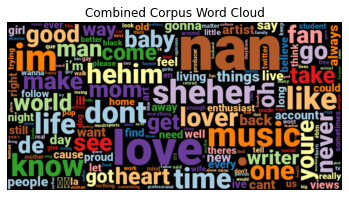

In [31]:
combined_corpus = pd.concat([df_lyrics_robyn, df_lyrics_cher, twitter_data_robyn, twitter_data_cher])

word_freq = count_words(combined_corpus, column='tokens', min_freq=5)

wordcloud(word_freq['freq'], title='Combined Corpus Word Cloud')




Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: I did one wordcloud for all four of my corporas. Combined looks like the theme is still love. Definitely still related to personal pronouns. The words are still very informal like, something that is unlikely to be in medical documentation. The text corpus are both lyrics and twitter descriptions it makes sense they are informal and very personal. It is helpful to know that the people following the artists encompass or embody similar themese in their descriptions. This may help when attempting to work on new content. 